In [31]:
# this program will read in the felony data and combine it with performance data by precinct
# it will then analyze the data for college career rate in 2014 vs the average felony rate

# dependencies and setup
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pylab as pl

# files to load
crime_report = "../Resources/seven-major-felony-offenses-by-precinct-2000-2017.xls" # https://www1.nyc.gov/site/nypd/stats/crime-statistics/historical.page
hs_performance = "../Resources/Combined_HS_Performance_Data.csv"

# read files and store into pandas data frames
crime_data = pd.read_excel(crime_report)
hs_data = pd.read_csv(hs_performance)

In [32]:
# get rid of blank spaces in column 1 of the felony data
i = 0
j = 0
for row in crime_data["Seven Major Felony Offenses"]:
    try:
        if math.isnan(row):
            crime_data["Seven Major Felony Offenses"][i] = j
        else:
            j = row
    except TypeError:
        pass
    i += 1

C:\Users\Allen\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [33]:
# create a marker column that indicates a row that we want to keep
i = 0
crime_data["marker"] = np.nan

for row in crime_data["Unnamed: 1"]:
    try:
        if row == "TOTAL SEVEN MAJOR FELONY OFFENSES":
            crime_data["marker"][i] = 1
    except TypeError:
        pass
    i += 1

C:\Users\Allen\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
# drop any rows where the marker is not populated
crime_data = crime_data.dropna(how='any')

In [35]:
# drop unneeded columns
crime_data = crime_data.drop(columns= ["Unnamed: 1", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "marker"])

In [36]:
# rename columns to be used
# we chose to use an average of the years 2008-2013 to compare to the college rate of 2014
# this encompasses the middle school years and up to junior year of a typical 2014 HS graduate, which
# we felt was more suitable than felony data for 1 year.
crime_data = crime_data.rename(index=str, columns={"Seven Major Felony Offenses": "Precinct", 
                                                   "Unnamed: 10": "major_felonies_2008",
                                                   "Unnamed: 11": "major_felonies_2009",
                                                   "Unnamed: 12": "major_felonies_2010",
                                                   "Unnamed: 13": "major_felonies_2011",
                                                   "Unnamed: 14": "major_felonies_2012",
                                                   "Unnamed: 15": "major_felonies_2013"})

In [37]:
# cast Precint as int prior to merge
crime_data["Precinct"] = crime_data["Precinct"].astype(int)

# get the average of the felony data for 2008-2013
crime_data["average"] = (crime_data["major_felonies_2008"] + crime_data["major_felonies_2009"] + crime_data["major_felonies_2010"] + crime_data["major_felonies_2011"] + crime_data["major_felonies_2012"] + crime_data["major_felonies_2013"]) / 6

# merge data
performance_felony_data = hs_data.merge(hs_data.merge(crime_data, how='left', on='Precinct', sort=False))

# get the felony rate per 1000 people
performance_felony_data["felony_rate"] = performance_felony_data["average"] / performance_felony_data["Population"] * 1000

In [38]:
# select columns to be used and drop any rows with missing data
graph_data = performance_felony_data[["college_career_rate_2014", "felony_rate"]].dropna(how="any")

# multiply rate by 100 to show percentage on y-axis
graph_data["college_career_rate_2014"] = graph_data["college_career_rate_2014"] * 100

y=-0.33842511381512863x+58.547615642681926


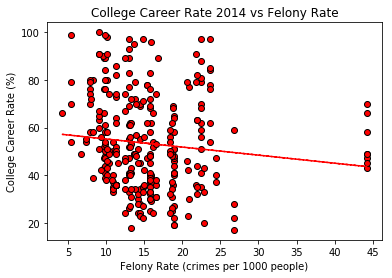

In [40]:
# scatter plot
x = graph_data["felony_rate"]
y = graph_data["college_career_rate_2014"]

plt.scatter(x, y, marker="o", facecolors="red", edgecolors="black")

plt.title("College Career Rate 2014 vs Felony Rate")
plt.xlabel("Felony Rate (crimes per 1000 people)")
plt.ylabel("College Career Rate (%)")

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pl.plot(x,p(x),"r--")

# the line equation:
print(f"y={z[0]}x+{z[1]}")

plt.savefig("../Images/FelonyRate_vs_CollegeRate.png")
plt.show()

In [41]:
# create bins
bins = [0, 30, 50, 70, 85, 100]
group_names = ["0-30%", "30-50%", "50-70%", "70-85%", "85-100%"]

graph_data["Summary"] = pd.cut(graph_data["college_career_rate_2014"], bins, labels=group_names)

grouped_graph_data = graph_data.groupby(by="Summary")

# calculate means and sems of the bins
means = grouped_graph_data["felony_rate"].mean()
sem = grouped_graph_data["felony_rate"].sem()

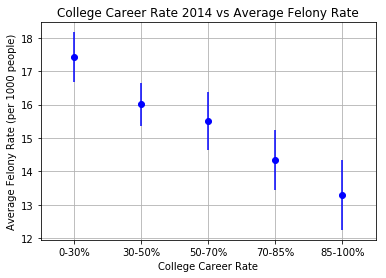

In [43]:
# plot means with error bars
fig, ax = plt.subplots()

ax.errorbar(np.arange(0, len(means)), means, yerr=sem, fmt="o", color="b")

ax.set_xlim(-0.5, len(means)-0.5)
ax.set_xticklabels(group_names)
ax.set_xticks([0, 1, 2, 3, 4])

ax.set_title("College Career Rate 2014 vs Average Felony Rate")
ax.set_xlabel("College Career Rate")
ax.set_ylabel("Average Felony Rate (per 1000 people)")

plt.grid()
plt.savefig("../Images/Bin_CollegeRate_vs_FelonyRate.png")
plt.show()

In [44]:
# t-test for "0-30%" group vs the rest
x = graph_data.loc[graph_data["Summary"] == "0-30%"]["felony_rate"]
y = graph_data.loc[graph_data["Summary"] != "0-30%"]["felony_rate"]

(t_stat, p) = ttest_ind(x, y, equal_var=False)

print(f"p=value:{p}")

p=value:0.02203323933933972


In [45]:
# t-test for "30-50%" group vs the rest
x = graph_data.loc[graph_data["Summary"] == "30-50%"]["felony_rate"]
y = graph_data.loc[graph_data["Summary"] != "30-50%"]["felony_rate"]

(t_stat, p) = ttest_ind(x, y, equal_var=False)

print(f"p=value:{p}")

p=value:0.3656236650986603


In [46]:
# t-test for "50-70%" group vs the rest
x = graph_data.loc[graph_data["Summary"] == "50-70%"]["felony_rate"]
y = graph_data.loc[graph_data["Summary"] != "50-70%"]["felony_rate"]

(t_stat, p) = ttest_ind(x, y, equal_var=False)

print(f"p=value:{p}")

p=value:0.9132398520653336


In [47]:
# t-test for "70-85%" group vs the rest
x = graph_data.loc[graph_data["Summary"] == "70-85%"]["felony_rate"]
y = graph_data.loc[graph_data["Summary"] != "70-85%"]["felony_rate"]

(t_stat, p) = ttest_ind(x, y, equal_var=False)

print(f"p=value:{p}")

p=value:0.15177220431770805


In [48]:
# t-test for "85-100%" group vs the rest
x = graph_data.loc[graph_data["Summary"] == "85-100%"]["felony_rate"]
y = graph_data.loc[graph_data["Summary"] != "85-100%"]["felony_rate"]

(t_stat, p) = ttest_ind(x, y, equal_var=False)

print(f"p=value:{p}")

p=value:0.03628164847146017
